# Changelog:

Last Update: 2022-03-11

Changes:

1. token_to_index returns `vocab[token]`

# Question 2: Natural Language Processing

### Total Points: 46

### Background:
In this question you will fit a set of models with the goal of predicting which text messages (SMS) are spam and which are not. 

You will be experimenting with a variety of different embedding algorithms followed by Logistic Regression.

In [ ]:
!pip install datasets
!python -m spacy download en_core_web_md
!pip install transformers

     |████████████████████████████████| 325 kB 2.7 MB/s 
     |████████████████████████████████| 1.1 MB 27.2 MB/s 
     |████████████████████████████████| 67 kB 3.6 MB/s 
     |████████████████████████████████| 212 kB 6.3 MB/s 
     |████████████████████████████████| 134 kB 50.7 MB/s 
     |████████████████████████████████| 127 kB 47.0 MB/s 
     |████████████████████████████████| 144 kB 44.2 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 271 kB 22.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 96.4 MB 1.2 MB/s 


## Data Loading, Exploratory Data Analysis and Vocabulary Creation:


In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from typing import List
import numpy as np 
import pandas as pd
from tqdm import tqdm
import torch
np.random.seed(42)

In [ ]:
dataset = load_dataset("sms_spam")
texts = [x["sms"] for x in dataset["train"]]
labels = [x["label"] for x in dataset["train"]]

Reusing dataset sms_spam (/root/.cache/huggingface/datasets/sms_spam/plain_text/1.0.0/53f051d3b5f62d99d61792c91acefe4f1577ad3e4c216fb0ad39e30b9f20019c)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
X_train, X_m, y_train, y_m = train_test_split(texts, labels, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_m, y_m, test_size = 0.5, random_state=0)

In [ ]:
def tokenize(x:str) -> List[str]:
  """
  Takes string as an input and returns a list of tokens. This just splits the string x on whitespace
  """
  return x.lower().split(" ")

##[ 5 points ] Q2.a: Determine / Answer the following: 

*   How many datapoints are in the training set?
*   How many total tokens are there in the data?
*   What % of training examples are spam?
*   What would the accuracy be if for every datapoint we predict it is spam? (explain)





In [ ]:
s = 0
for text in texts:
  s += len(tokenize(text))
print(s)

87535


In [ ]:
sum(y_test)/len(y_test)

0.16367980884109917

In [ ]:
texts[2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's\n"

Answers:
*   How many datapoints are in the training set?

As the length of the training set is $3901$, we have $3901$ datapoints.

*   How many total tokens are there in the data? $87535$
*   What % of training examples are spam? $12.95 \% $ of training examples are spam.
*   What would the accuracy be if for every datapoint we predict it is spam? (explain)

It would just be the number of $1$'s in the test set as we denote $1$ as spam and $0$ otherwise, meaning that if we predict all datapoint as spam, then only the $1$'s in the corresponding positions in the test set would be correct. The accuracy then is $16.37 \% $

##[4 points ] Q2.b Vocabulary and Frequencies  

Implement the functions `create_count_dict`, and `create_vocab` below that take as input a dataset (list of untokenized strings - one per datapoint), and an integer representing the desired vocabulary size, and returns the vocabulary as a `dict` whose keys are tokens and whose values are indices.

In [ ]:
def create_count_dict(dataset:List[str]) -> dict:
  """
  Given a dataset, returns a dictionary of token counts with tokens being keys, and counts being values
  """
  count_dict = {}
  # TODO
  for text in dataset:
    tokens = tokenize(text)
    for token in tokens:
      if token in count_dict:
        count_dict[token] += 1
      else:
        count_dict[token] = 1

  return count_dict

def create_vocab(dataset:List[str], vocab_size:int) -> dict:
  """
  Given a dataset, returns a dictionary with tokens as keys and indices as values.

  {"token_1": 1, "token_2": 2, ...}
  """

  # TODO: 
  # 1. Determine the count of all words
  count_dict = create_count_dict(dataset)
  # 2. Keep the top <vocab_size> tokens
  df = pd.DataFrame(data={"token": [key for key, _ in count_dict.items()], 
                          "count": [value for _, value in count_dict.items()]}).sort_values("count", ascending=False)[:vocab_size]
  
  # 3. Create the token to index dict and fill it with just the top tokens
  vocab_to_index_dict = {}
  for i in range(vocab_size):
    token_info = df[["token"]].iloc[i]
    vocab_to_index_dict[token_info[0]] = i
  return vocab_to_index_dict

In [ ]:
# Helper test to at least ensure the constructed vocab is the right size
for i in np.random.randint(low = 100, high = 500, size = 5):
  assert(len(create_vocab(X_train, vocab_size = i)) == i)

In [ ]:
# Create and save your vocab
student_created_count_dict = create_count_dict(X_train)
student_created_vocab = create_vocab(X_train, vocab_size = 500)

##[4 points] Q2.c Token Counts

### Q2.c.a  Is the distribution of token counts below a relatively heavy-tailed distribution?  Would using only the top 30 tokens be sufficient for most applications?

In [ ]:
def visualize_top_token_distribution(count_dict, num_tokens_to_plot):
  """
  Display a barplot of counts of top <num_tokens_to_plot> tokens in the <count_dict>
  """
  df = pd.DataFrame(data={"token": [key for key, _ in count_dict.items()], "count": [value for _, value in count_dict.items()]}).sort_values("count", ascending=False)
  df[:num_tokens_to_plot].plot(x = "token", y = "count", kind="bar")

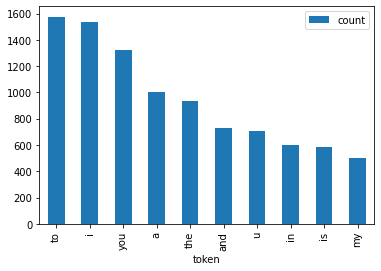

In [ ]:
visualize_top_token_distribution(student_created_count_dict, 10)

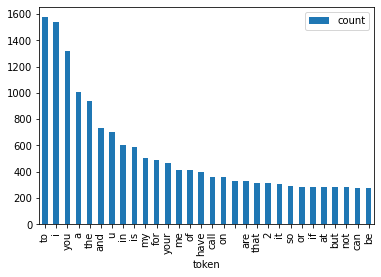

In [ ]:
visualize_top_token_distribution(student_created_count_dict, 30)

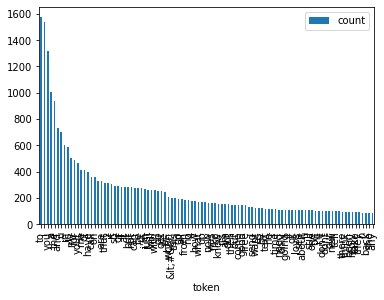

In [ ]:
visualize_top_token_distribution(student_created_count_dict, 100)

It is quite heavy-tailed as one can see, and only the top 30 tokens have counted for most of the probability. However, most of the top 30 tokens are common words in almost any English sentences, and so it may not be enough for our task, and so not sufficient for most applications.

### Q2.c.b [2 points] Take a look at the top 10 tokens in the plot above, do you think the embeddings based on those tokens will be informative for our task?


No. The top 10 tokens are all common words shown in almost every English sentences, whether or not it is spam or not.

## Q2.d [ 13 points ] Vocabulary selection and Embeddings

In [ ]:
# NOTHING TO DO HERE, JUST SOME CONVENIENCE FUNCTIONS FOR THE FUTURE
def index_to_token(index:int, vocabulary:dict) -> str:
  """
  Given an index in the vocabulary, and the vocabulary dict with tokens as keys, and indices as values, returns the token that maps to the given index
  """
  if index > len(vocabulary):
    raise ValueError(f"There is no index {index} in the vocabulary")
  inv_vocabulary = {v: k for k, v in vocabulary.items()}
  return inv_vocabulary[index]

def token_to_index(token:str, vocabulary:dict) -> int:
  """
  Given a token, return the index of that token in the vocabulary
  """
  token = vocabulary.get(token)
  if token is None:
    raise ValueError(f"Token: {token} is not in the vocabulary")
  return vocabulary[token]

In [ ]:
## NOTHING TO DO HERE

# BoW with our vocab
vectorizer_ours = CountVectorizer(max_features=500, tokenizer=tokenize, vocabulary=student_created_vocab) # Automatic BoW embeddings using your vocab
vectorized_data_ours = vectorizer_ours.fit_transform(X_train) # Embedded data

# Bow with an auto vocab
vectorizer_auto = CountVectorizer(max_features=500) # Automatic BoW embeddings and automatic vocab
vectorized_data_auto = vectorizer_auto.fit_transform(X_train) # Embedded data
VOCAB = vectorizer_auto.vocabulary_ # For convenience

# binary BoW
vectorizer_bbow = CountVectorizer(max_features=500, binary=True, vocabulary=VOCAB) # Automatic binary BoW embeddings using the automatically generated vocab above
vectorized_data_bbow = vectorizer_bbow.fit_transform(X_train) # Embedded data

# TFIDF
tfidf_transformer = TfidfTransformer(smooth_idf=False) # TF-IDF transformer for BoW embeddings
vectorized_data_tfidf_auto = tfidf_transformer.fit_transform(vectorized_data_auto) # Embedded data

### Q2.d.a [ 2 points ] Implement the function `vocabulary_diff` below. It should return a list of tokens that are in `vocab_1` but not in `vocab_2`.

In [ ]:
# Get the differences between our vocabulary and the automatically generated one

def vocabulary_diff(vocab_1:dict, vocab_2:dict) -> List[str]:
  """
  Given 2 vocabularies, returns all the tokens that are present in vocab_1 but not in vocab_2
  """
  vocab_diff = list(set(key for key, _ in vocab_1.items()) - set(key for key, _ in vocab_2.items())) # TODO
  return vocab_diff


print(vocabulary_diff(student_created_vocab,VOCAB))
print(vocabulary_diff(VOCAB, student_created_vocab))

['', 'wil', 'now.\n', 'it,', '-', '6', 'later\n', 'no.', 'you.', '+', '.', 'k', "i'll", 'r', '5', '3', "we're", "he's", 'u.', 'yeah,', 'y', '...', 'n', 'lor.\n', "i've", '\n', 'wif', '£500', "that's", '?\n', 'you\n', 'g', "can't", 'e', 'i', "i'm", '1', 'now.', 'makes', 'me.', '!', '&amp;', 'sorry,', '£100', 'took', 'stay', '&lt;decimal&gt;', 'lor...', 'c', 'it.\n', 'tomorrow\n', "there's", 'now!', '&', 'da.', 'a', "it's", 'home.', 'saying', 'me.\n', '4', "you're", "how's", 'ok.', 'v', 'day.', '&lt;#&gt;', 'x', 'it.', '?', ',', 'i.ll', 'you,', 'lor.', 'juz', '*', 'needs', 'you!', "didn't", '.\n', 'urgent!', 'u', '2', 'day.\n', 'b', 'd', 'ü', "don't", 'me\n', '£1000', 'you.\n', ':)\n', 'lor...\n']
['www', 'landline', 'yet', 'lar', 'easy', 'cs', 'drive', 'co', 'min', 'line', 'afternoon', 'book', 'didn', 'office', 'fine', 'hours', '150ppm', 've', '000', 'cool', 'times', 'worry', 'hour', 'sir', 'don', 'anyway', 'bored', 'll', 'mob', 'evening', 'online', 'word', 'gt', 'xxx', 'dreams', 'room'

###  Q2.d.b [3 points] Based on the differences between the two vocabularies, which do you think will represent our datapoints better? Why? 

The *student_created_vocab* will be better because it includes words like "urgent!", "now!", "you!", which are the ones that normally show up in the spam messages.

In [ ]:
# Some convenience constants
DOCUMENT_COUNTS = np.bincount(vectorized_data_bbow.indices, minlength=vectorized_data_bbow.shape[1])
NUM_DATAPOINTS = len(X_train)
VOCAB = vectorizer_auto.vocabulary_

### Q2.d.c [3 points] Implement the `idf` function below which returns the inverse document frequency of a given word as defined by:

$$ IDF(w_j) = log(\frac{N}{N_j}) + 1 $$

where:

* $N$ is the number of datapoints 

* $N_j$ is the number of occurences of word $w_j$ in the data

In [ ]:
def idf(word:str, document_count:np.ndarray=DOCUMENT_COUNTS, num_datapoints:int=NUM_DATAPOINTS) -> float:
  """
  returns the inverse document frequency of a particular word, based on the IDF definition of

  IDF(w_j) = log(N / N_j) + 1

  """
  # TODO
  return 1 + np.log(num_datapoints / document_count[VOCAB[word]])
  pass

In [ ]:
for index in np.random.randint(0,500, size=15).tolist():
  print(f"word: {index_to_token(index, VOCAB)}")
  print(f"your idf: {idf(index_to_token(index, VOCAB))}")
  print(f"calculated idf: {tfidf_transformer.idf_[index]}")
  assert np.isclose(tfidf_transformer.idf_[index], idf(index_to_token(index, VOCAB)))

word: service
your idf: 5.58010875539272
calculated idf: 5.58010875539272
word: forgot
your idf: 6.133493993577507
calculated idf: 6.133493993577507
word: easy
your idf: 6.273255935952665
calculated idf: 6.273255935952665
word: first
your idf: 5.555416142802349
calculated idf: 5.555416142802349
word: or
your idf: 3.634198606337407
calculated idf: 3.634198606337407
word: maybe
your idf: 6.324549230340216
calculated idf: 6.324549230340216
word: really
your idf: 5.243636518771507
calculated idf: 5.243636518771507
word: yeah
your idf: 5.158114345333345
calculated idf: 5.158114345333345
word: time
your idf: 4.2583529154104
calculated idf: 4.2583529154104
word: nothing
your idf: 5.901692379520182
calculated idf: 5.901692379520182
word: stuff
your idf: 5.973151343502328
calculated idf: 5.973151343502328
word: hello
your idf: 5.867790827844501
calculated idf: 5.867790827844501
word: wait
your idf: 5.37716791139603
calculated idf: 5.37716791139603
word: morning
your idf: 5.191450765600937
calcu

### Q2.d.d [2 points] Implement a binary Bag of Words embedding function that takes in a list of token and a vocab, and returns a numpy array corresponding to the embedding vector

In [ ]:
def binary_BoW_embedder(list_of_tokens:List[str], vocab:dict) -> np.ndarray:
  """
  Creates a binary Bag of Words embedding of a datapoint represented as a list of tokens, using the vocab
  """
  # Hint: you may want to start with np.zeros()
  embedding = np.zeros(len(vocab)) # TODO
  for i in range(len(list_of_tokens)):
    if list_of_tokens[i] in list(vocab.keys()):
      embedding[vocab[list_of_tokens[i]]] = 1
  return embedding

In [ ]:
for test_num in range(15):
  sample_token_indices = np.random.randint(0,500, size=10)
  input_text = [index_to_token(index, VOCAB) for index in sample_token_indices]
  input_text_as_str = " ".join(input_text)
  print(f"text: {input_text}")
  if test_num == 0:
    print(f"your embedding: {binary_BoW_embedder(input_text, VOCAB)}")
    print(f"calculated embedding: {vectorizer_bbow.transform([input_text_as_str]).toarray()}")
  assert np.isclose(binary_BoW_embedder(input_text, VOCAB), vectorizer_bbow.transform([input_text_as_str]).toarray()).all()
  print("Success!")

text: ['enjoy', 'ah', 'plus', 'going', 'money', 'sweet', 'code', 'pain', 'about', 'long']
your embedding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.

### Q2.d.e [2 points] Implement a Bag of Words embedding function that takes in a list of token and a vocab, and returns a numpy array corresponding to the embedding vector

In [ ]:
def BoW_embedder(list_of_tokens, vocab):
  """
  Creates a Bag of Words embedding of a datapoint represented as a list of tokens, using the vocab
  """
  # Hint: You may want to start with np.zeros()
  embedding = np.zeros(len(vocab)) # TODO
  for i in range(len(list_of_tokens)):
    if list_of_tokens[i] in list(vocab.keys()):
      embedding[vocab[list_of_tokens[i]]] = list_of_tokens.count(list_of_tokens[i])
  return embedding

In [ ]:
for test_num in range(15):
  sample_token_indices = np.random.randint(199,204, size=10)
  input_text = [index_to_token(index, VOCAB) for index in sample_token_indices]
  input_text_as_str = " ".join(input_text)
  print(f"text: {input_text}")
  if test_num == 0:
    print(f"your embedding: {BoW_embedder(input_text, VOCAB)}")
    print(f"calculated embedding: {vectorizer_auto.transform([input_text_as_str]).toarray()}")
  assert np.isclose(BoW_embedder(input_text, VOCAB), vectorizer_auto.transform([input_text_as_str]).toarray()).all()
  print("Success!")

text: ['hope', 'hope', 'hour', 'home', 'home', 'hours', 'holiday', 'hours', 'hour', 'hour']
your embedding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 2. 2. 3. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 

##Q2.e [11 points] Model Fitting

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
logreg_auto = LogisticRegression(random_state=1).fit(vectorized_data_auto, y_train)
logreg_bbow = LogisticRegression(random_state=1).fit(vectorized_data_bbow, y_train)
logreg_tfidf = LogisticRegression(random_state=1).fit(vectorized_data_tfidf_auto, y_train)

### Q2.e.a [3 points] Evaluation Metrics
Below you can see a set of simple accuracy scores: 

https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score

In what situation would accuracy be a good evaluation metric? In what situation it wouldn't? 

In [ ]:
print(f" All 1s; accuracy on validation data: {accuracy_score(y_val, np.ones_like(y_val))}")

print(f" All 0s; accuracy on validation data: {accuracy_score(y_val, np.zeros_like(y_val))}")

print(f" Logistic Regression on BoW embedding; accuracy on validation data: {accuracy_score(y_val, logreg_auto.predict(vectorizer_auto.transform(X_val)))}")

print(f" Logistic Regression on binary BoW embedding; accuracy on validation data: {accuracy_score(y_val, logreg_bbow.predict(vectorizer_bbow.transform(X_val)))}")

print(f" Logistic Regression on TF-IDF embedding; accuracy on validation data: {accuracy_score(y_val, logreg_tfidf.predict(tfidf_transformer.transform(vectorizer_auto.transform(X_val))))}")


 All 1s; accuracy on validation data: 0.1255980861244019
 All 0s; accuracy on validation data: 0.8744019138755981
 Logistic Regression on BoW embedding; accuracy on validation data: 0.9772727272727273
 Logistic Regression on binary BoW embedding; accuracy on validation data: 0.9808612440191388
 Logistic Regression on TF-IDF embedding; accuracy on validation data: 0.972488038277512


When the datasets are not balanced, i.e., the classes are not represented equally, the accuracy score would not be a good evaluation metric, and when the datasets are balanced, it is a good evaluation metric.

### Q2.e.b [8 points] Answer the following in one-two sentences (2 points each)

* What is the interpretation of coefficient $\beta_j$ with $j > 1$ (so not the intercept) in the Logistic regression model fit on the binary BoW embeddings?

* What is the interpretation of coefficient $\beta_j$ with $j > 1$ (so not the intercept) in the Logistic regression model fit on the BoW embeddings?

* If we were to include 1-st order interaction terms in our Logistic Regression model fit on binary BoW embeddings, what would be the interpretation of a coefficient for that interaction ?

* Is the above different from fitting a Logistic Regression on a combination of unigrams and bigrams (1-grams, and 2-grams)? Explain.

* With the presence of word j, the average change of logit being the spam text on the binary BoW embeddings is $β_j$.
* As one unit increases in the value of the BoW embeddings, the average change of logit of being the spam text on the BoW embeddings is $\beta_j$.
* The interpretation of a coefficient for that interaction can be thought as when two words show up at the same time, the average change of logit on the binary BoW embeddings. 
* Since the unigrams are for a single word, which is the first two cases, and bigrams are for two words together, which is the third case (interaction terms). Therefore, the interpretation of the combination model is the same as above.

## Q2.f [4 points] Word Vectors

Below we will be using a set of pre-trained word embeddings from the SpaCy library. For the purpose of the questions below, assume that they were trained
using a Skip-Gram objective as described in lecture.

In [ ]:
# This installs a full pipeline of tokenizer -> embedder with additional components.

import spacy
spacy_pipeline = spacy.load('en_core_web_md') # If this line produces an error,
# you might need to re-start the runtime after running the first cell.

### Q2.f.a [2 points] Implement the function get_document_embedding_from_spacy below to return the document embedding as the average of all vector embeddings.

You are not allowed to use `tokens.vector` in your functions, but you can check against it that your solution is accurate

In [ ]:
def get_document_embedding_from_spacy(text:str) -> np.ndarray:
  """
  returns the embedding vector representing the entire text by averaging the 
  word level embeddings.

  !! DO NOT USE tokens.vector directly!! 
  """
  tokens = spacy_pipeline(text)

  # Hint: you can iterate over each token in `tokens` and access the underlying vector with .vector
  document_embedding = np.zeros(len(tokens[0].vector))
  for token in tokens:
    document_embedding += token.vector
  document_embedding = document_embedding / len(tokens)
  return document_embedding

In [ ]:
# TEST FOR THE get_document_embedding_from_spacy function
for test_num in range(15):
  sample_token_indices = np.random.randint(0,500, size=10)
  input_text = [index_to_token(index, VOCAB) for index in sample_token_indices]
  input_text_as_str = " ".join(input_text)
  print(f"text: {input_text}")
  if test_num == 0:
    print(f"your embedding: {get_document_embedding_from_spacy(input_text_as_str)}")
    print(f"calculated embedding: {spacy_pipeline(input_text_as_str).vector}")
  assert np.isclose(get_document_embedding_from_spacy(input_text_as_str), spacy_pipeline(input_text_as_str).vector).all()
  print("Success!")

text: ['money', 'sweet', 'code', 'pain', 'about', 'long', 'might', 'remember', 'before', 'stuff']
your embedding: [-1.06683496e-01  2.10446421e-01 -2.65663899e-01  8.80070142e-03
 -1.20500959e-02  3.31952996e-02 -2.19533004e-02 -1.39289572e-01
  1.49224799e-01  2.27879602e+00 -2.43725107e-01  6.56326000e-02
  1.23016903e-01 -1.04415599e-01 -1.75938001e-01 -1.14011588e-01
 -4.22801018e-02  1.02470598e+00 -1.32739798e-01  4.28650939e-02
  1.25979902e-01  2.06488986e-02 -1.39824898e-01 -5.13607307e-02
 -1.29056800e-01 -3.46067605e-02  1.37392095e-01 -1.50759302e-01
  1.60280859e-01 -9.58130993e-02 -2.57375210e-02 -1.30341300e-02
  1.51485987e-02 -1.90062312e-02  1.43359898e-01  4.87049997e-02
 -3.03401207e-02  8.35300979e-02 -1.14900399e-01  9.38732982e-02
 -1.21561017e-02  1.05218501e-01  3.62546701e-02 -8.42121098e-02
  1.95649993e-02  2.43968701e-01 -1.37654100e-01 -8.51076972e-02
  2.52497004e-02  1.60060115e-03 -2.07404583e-01  4.42915011e-02
  6.78589903e-03  7.90099427e-04  1.44485

In [ ]:
# This might take around 1 minute to run
X_train_spacy = np.vstack([get_document_embedding_from_spacy(x) for x in X_train])
X_valid_spacy = np.vstack([get_document_embedding_from_spacy(x) for x in X_val])
logreg_w2v = LogisticRegression(random_state=1, max_iter=1000).fit(X_train_spacy, y_train)
print(f" Logistic Regression on Word2Vec embedding; accuracy on validation data: {accuracy_score(y_val , logreg_w2v.predict(X_valid_spacy))}")

 Logistic Regression on Word2Vec embedding; accuracy on validation data: 0.9677033492822966


### Q2.f.b [2 points] Implement the function get_document_embedding_from_spacy_alt below to return the document embedding based on the token vectors.

Feel free to let your imagination run, or go with simplicity. Don't use the average as above. Feel free to play around and see what works and what doesn't.

In [ ]:
def get_document_embedding_from_spacy_alt(text:str) -> np.ndarray:
  """
  returns the embedding vector representing the entire text by whatever means you
  would like based on the token level embeddings
  """
  tokens = spacy_pipeline(text)
  
  document_embedding = np.zeros(len(tokens[0].vector))
  for token in tokens:
    document_embedding += token.vector # just sum, not averaging

  return document_embedding

In [ ]:
# This might take around a 1 minute
X_train_spacy_alt = np.vstack([get_document_embedding_from_spacy_alt(x) for x in X_train])
X_valid_spacy_alt = np.vstack([get_document_embedding_from_spacy_alt(x) for x in X_val])
logreg_w2v_alt = LogisticRegression(random_state=1, max_iter=1000).fit(X_train_spacy_alt, y_train)
print(f" Logistic Regression on Word2Vec alternative embedding; accuracy on validation data: {accuracy_score(y_val , logreg_w2v_alt.predict(X_valid_spacy_alt))}")

 Logistic Regression on Word2Vec alternative embedding; accuracy on validation data: 0.9700956937799043


## Combining Embeddings [Free]

In [ ]:
X_train_combined = np.hstack((X_train_spacy, vectorized_data_auto.toarray()))
X_val_combined = np.hstack((X_valid_spacy, vectorizer_auto.transform(X_val).toarray()))
logreg_combined = LogisticRegression(random_state=1, max_iter=1000).fit(X_train_combined, y_train)
print(f" Logistic Regression on combined W2V and BoW embeddings; accuracy on validation data: {logreg_combined.score(X_val_combined, y_val)}")

 Logistic Regression on combined W2V and BoW embeddings; accuracy on validation data: 0.9832535885167464


##[2 points] Q2.g Transformer Model

Below we will be using embeddings produced by a "Transformer" model (we will learn more about these in week 12/13), for the embedding of each token, it aims to incorporate not only the meaning of the token, but also the specific context in which it occurs here, with the context being a fixed window of size 512.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection") # This model has been trained on this data

model = AutoModelForSequenceClassification.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection", output_hidden_states = True)

Downloading:   0%|          | 0.00/324 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/16.8M [00:00<?, ?B/s]

### Q2.g.a [2 points] Finish the implementation of get_embedding_from_transformer to produce a document level embedding given some text. 

In [ ]:
def get_embedding_from_transformer(text:str) -> np.ndarray:
  """
  Returns an embedding from a transformer model produced by averaging the token level embeddings
  """
  tokenized = tokenizer([text])
  for key, value in tokenized.items():
    tokenized[key] = torch.LongTensor(value)
  with torch.no_grad():
    token_embeddings = model.forward(**tokenized)["hidden_states"][0].numpy()[0]
  # print(token_embeddings.shape)
  document_embedding = np.mean(token_embeddings, axis=0) # TODO
  return document_embedding

In [ ]:
# JUST SOME TESTING THAT IT RUNS AND PRODUCES THE RIGHT SIZE
for e in [get_embedding_from_transformer(x) for x in X_train[:3]]:
  assert e.shape == (128,)

In [ ]:
# This might take around a 1 minute
X_train_transformer = np.vstack([get_embedding_from_transformer(x) for x in X_train])
X_valid_transformer = np.vstack([get_embedding_from_transformer(x) for x in X_val])
logreg_transformer = LogisticRegression(random_state=1, max_iter=1000).fit(X_train_transformer, y_train)
print(f" Logistic Regression on Transformer embedding accuracy on validation: {logreg_transformer.score(X_valid_transformer, y_val)}")

 Logistic Regression on Transformer embedding accuracy on validation: 0.9844497607655502


## Q2.h [3 points] Which spam detection method worked best? Why do you think that is? What are some considerations you would need to make to use this model in practice? 

The Transformer model worked best. The reason is that Transformer model incorporates not only the meaning of the token, but also the specific context in which it occurs here, and so it can extract more information than other two methods did. In practice, it would typically take into the model complexity in terms of the size, the time to train, and also one need to fine-tune the model for the downstream task properly when using the Transformer model.